<a href="https://colab.research.google.com/github/aquantumreality/ML/blob/main/GridSearch_vs_RandomSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np

non_convex_function = lambda x: 100 + (x-20)**2 + x**2 * np.cos(x*np.pi) ##This is our cost function for this case. 

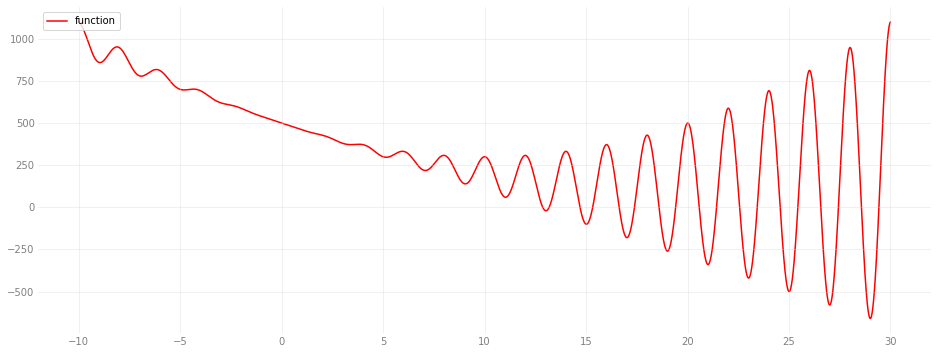

In [ ]:
def setup_ax():
    """
    Set up the plot axis to look prettier.
    """
    ax = plt.gca()
    ax.set_axisbelow(True)
    ax.grid(True, color='lightgrey', linestyle='-', alpha=0.4)
    ax.tick_params(axis='both', which='both', length=0, labelcolor='0.5')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

def plot_function(f, x_min, x_max):
    """
    Plot the given function in the interval [x_min, x_max].
    :param f: function to plot
    :param x_min: left side of the interval
    :param x_max: right side of the interval
    """
    plt.figure(facecolor="white", figsize=(16, 6))
    
    setup_ax()
    
    x = np.arange(x_min, x_max, 0.01)
    
    plt.plot(x, 
             f(x), 
             c='r', 
             zorder=0, 
             label='function')
    
    plt.legend(loc='upper left')

# Intervals for the experiments [X_MIN, X_MAX]
X_MIN = -10
X_MAX = 30

plot_function(non_convex_function, X_MIN, X_MAX)


We can see that there are many local minima which is what makes it harder for algorithms to find a global minima. So, that is why we need efficient search algorithms to tune the hyperparameters. The x-axis contains the set of hyperparameters for this cost function, which is on the y-axis. 

In [ ]:
from hyperopt import fmin, rand, hp, Trials


# Random states to make the experiments reproducible
RANDOM_STATES = [1, 2, 3, 4]


def get_best_value(f, candidates):
    """
    Return the candidate that yielded the lowest cost in the function f.
    :param f: cost function
    :param candidates: x candidates
    :return: the best candidate
    """
    idx_min = np.argmin(f(candidates))
    return candidates[idx_min]


def plot_search(search_type, f, candidates, x_min, x_max, selected_value):
    """
    Plot the given function in the interval [x_min, x_max], 
    search candidates and selected value.
    :param search_type: the type of the search to be set as title
    :param f: cost function
    :param candidates: search candidates
    :param x_min: left side of the interval
    :param x_max: right side of the interval
    :param selected_value: selected value among the candidates
    """
    # Cost function
    plot_function(f, x_min, x_max)
    
    # Candidates
    plt.scatter(candidates, 
                f(candidates), 
                color='firebrick', 
                zorder=1, 
                label='candidate')
    
    # Best value
    plt.scatter(selected_value, 
                f(selected_value), 
                color='steelblue', 
                marker='*', 
                s=200, 
                zorder=2, 
                label='best value: {0:.2f}'.format(selected_value))
    
    plt.title('[{0}] Cost for best value: {1:.2f}' \
        .format(search_type, f(selected_value)))
    plt.legend(loc='upper left')


def run_grid_search_experiment(f, n_trials, show_plot):
    """
    Run the experiment for grid search.
    :param f: cost function
    :param n_trials: number of trials
    :param show_plot: show plot if true
    :return: the best candidate
    """
    gs_candidates = np.linspace(X_MIN, X_MAX, n_trials)
    selected_value = get_best_value(f, gs_candidates)
    
    if show_plot:
        plot_search('Grid Search', 
                    f, 
                    gs_candidates, 
                    X_MIN, 
                    X_MAX, 
                    selected_value)
    
    return selected_value


def run_random_search_experiment(f, n_trials, random_state, show_plot):
    """
    Run the experiment for random search.
    :param f: cost function
    :param n_trials: number of trials
    :param random_state: value to make the experiment reproducible
    :param show_plot: show plot if true
    :return: the best candidate
    """
    trials = Trials()
    
    fmin(fn=f, 
         space=hp.uniform('x', X_MIN, X_MAX), 
         algo=rand.suggest, 
         max_evals=n_trials, 
         trials=trials,
         rstate=np.random.RandomState(random_state),
         show_progressbar=False)
    
    rs_candidates = \
        np.array([t['misc']['vals']['x'] for t in trials.trials]).flatten()

    # note: fmin already returns the best value, but let's use our function :)
    selected_value = get_best_value(f, rs_candidates)

    if show_plot:
        plot_search('Random Search', 
                    f, 
                    rs_candidates, 
                    X_MIN, 
                    X_MAX, 
                    selected_value)
    
    return selected_value


def run_experiments(f, n_trials, random_state, show=False):
    """
    Run the experiments for grid search and random search.
    :param f: cost function
    :param n_trials: number of trials
    :param random_state: value to make the experiment reproducible
    :param show: show plot and winner if true
    :return: the best candidates found for grid search and random search
    """
    gs_selected_value = run_grid_search_experiment(f, 
                                                   n_trials, 
                                                   show)

    rs_selected_value = run_random_search_experiment(f, 
                                                     n_trials, 
                                                     random_state, 
                                                     show)
    
    if show:
        print_winner(f, 
                     gs_selected_value, 
                     rs_selected_value)

    return gs_selected_value, rs_selected_value


def has_gs_won(f, gs, rs):
    """
    Evaluate the best candidates in the function f
    and return whether grid search has won or not.
    The lower cost the better.
    For simplicity, a tie gives the victory to grid search.
    :param f: cost function
    :param gs: best value found with grid search
    :param rs: best value found with random search
    """
    cost_gs = f(gs)
    cost_rs = f(rs)
    
    return cost_gs <= cost_rs


def print_winner(f, gs, rs):
    """
    Evaluate the best candidates in the function f and print the winner.
    :param f: cost function
    :param gs: best value found with grid search
    :param rs: best value found with random search
    """
    
    if has_gs_won(f, gs, rs):
        print('Grid Search is the winner!')
    else:
        print('Random Search is the winner!')

###Case 1 : 10 Trials

Random Search is the winner!


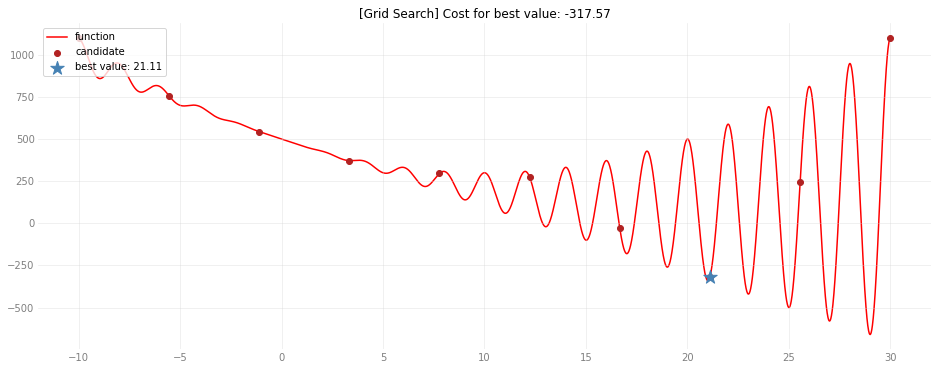

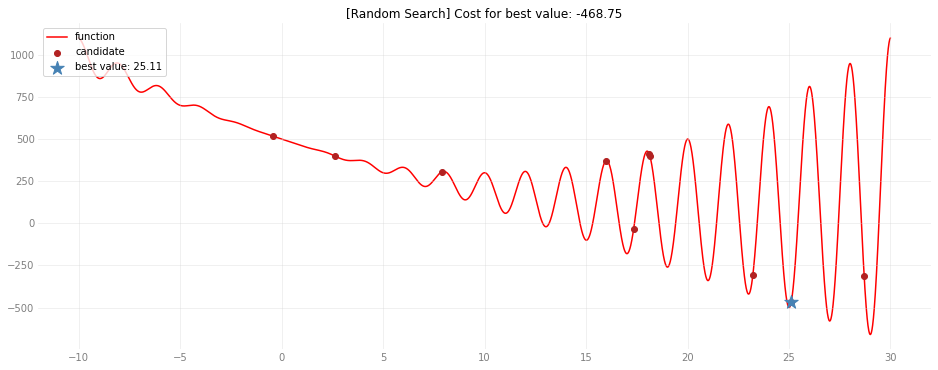

In [ ]:
gs, rs = run_experiments(non_convex_function, 10, RANDOM_STATES[0], show=True)

###Case 2 : 50 trials

Grid Search is the winner!


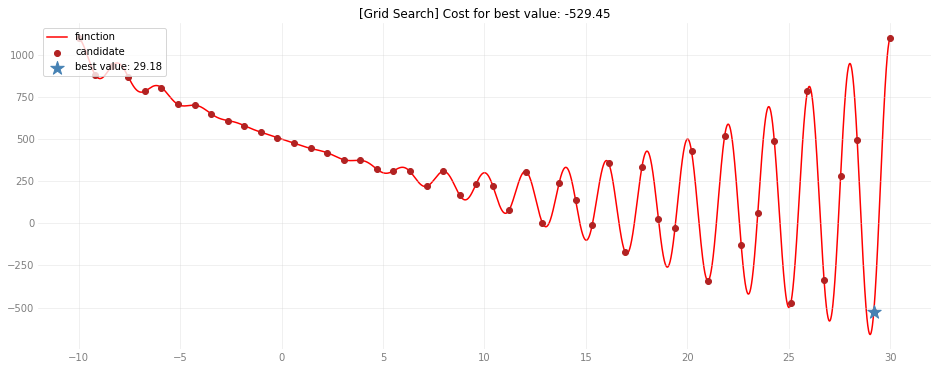

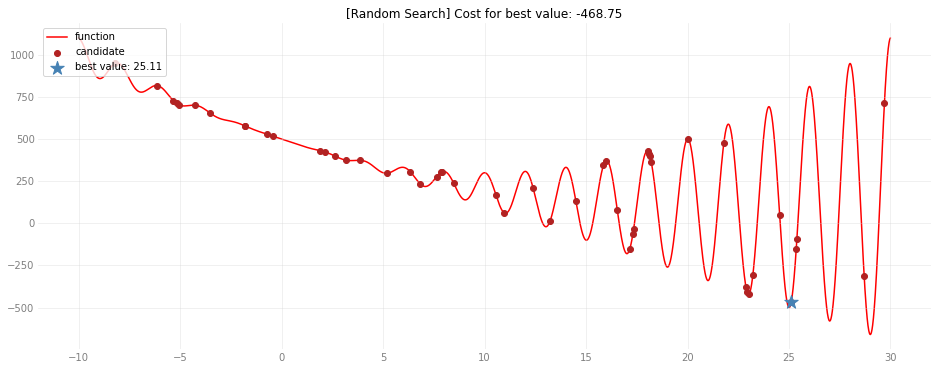

In [ ]:
gs, rs = run_experiments(non_convex_function, 50, RANDOM_STATES[0], show=True)

###Case 3 : 100 trials

Random Search is the winner!


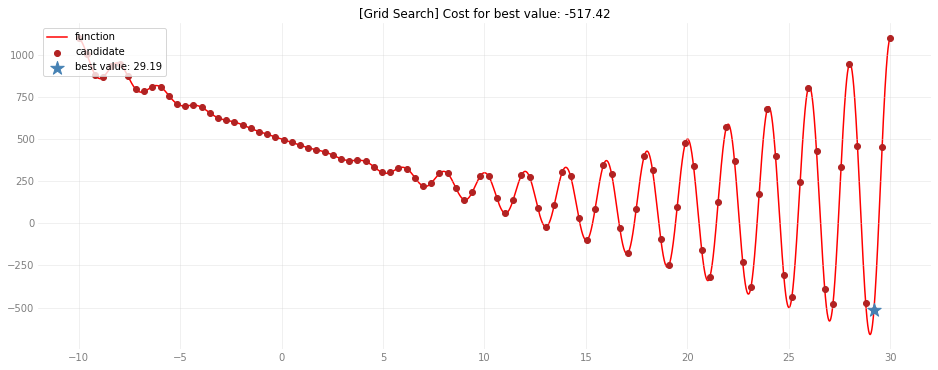

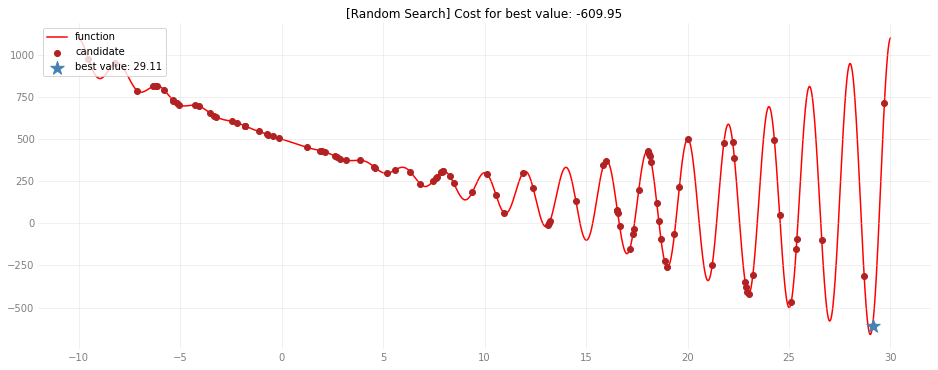

In [ ]:
gs, rs = run_experiments(non_convex_function, 100, RANDOM_STATES[0], show=True)

###Case 4 : 500 trials

Random Search is the winner!


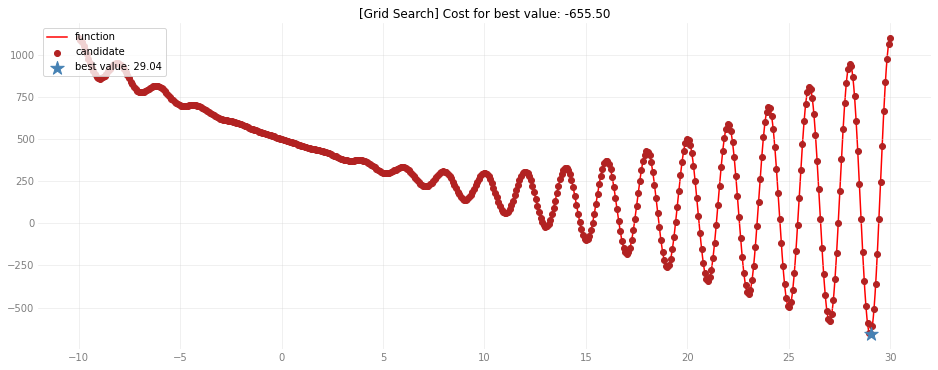

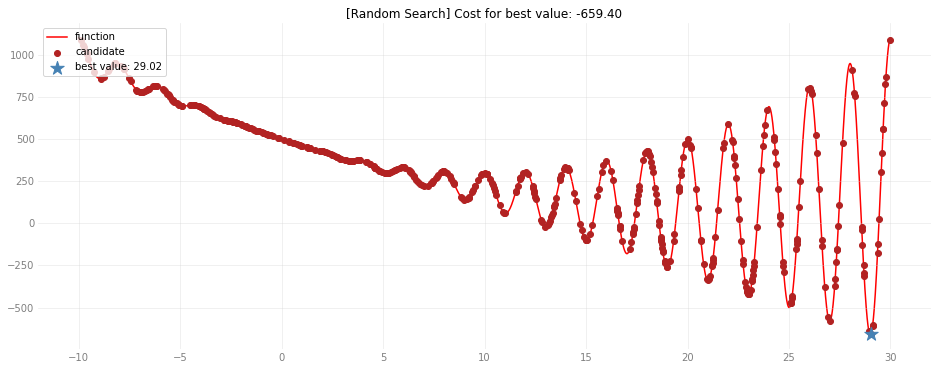

In [ ]:
gs, rs = run_experiments(non_convex_function, 500, RANDOM_STATES[0], show=True)

So, we can conclude that Random Search is the winner for 3 out of the 4 cases we've seen above, and it can act as a very efficient alternative to Grid Search. But we can't directly conclude which one is better, it is a better strategy to try out both the searches when optimizing the hyperparameters. 

If you have many hyperparameters with an awkward search space , starting off with Random Search is better. If the cost varies signficantly around the optimum points, the hyperparameters can be fine-tuned using Grid Search. 